<center><h1> Fitting a Single Frame.

Let's crawl before we run. Here we will extract a normalized hologram from experimental data then fit said hologram to, you guessed it, the Lorenz-Mie theory. With any luck and/or scientific consistency, the fitting procedure will return the same parameters we used to generate the hologram.

In [1]:
# The Usual Suspects.
import numpy as np 
import scipy as sp    
import pandas as pd   
import os
import cv2

In [3]:
# For our particular case.
import trackpy as tp      
from pylorenzmie.theory import LMHologram, Instrument
from pylorenzmie.fitting.mie_fit import Mie_Fitter
from lmfit import report_fit
from tracker import tracker

In [ ]:
import mie_video.tracking as trk
import mie_video.utilities.editing as edit

In [2]:
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=2)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


## Extracting a frame.

In [3]:
# Get raw data
folder = os.path.expanduser("../animation/")
fn = "example.avi"
cap = cv2.VideoCapture(os.path.join(folder, fn))
ret, frame = cap.read()
if ret is False:
    print("Failed")
else:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float)

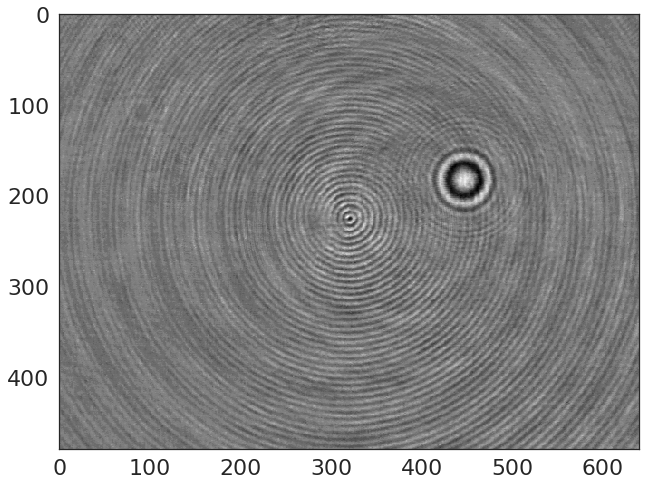

In [8]:
# Plot normalized frame
frame = frame / np.mean(frame)
plt.imshow(frame, cmap='gray')

## Find the holographic feature.

In [9]:
# Use find features with oat
locate_params = {'diameter': 51, 'minmass': 25.}
features, circle_transform = trk.oat(frame, locate_params=locate_params)

Time to find 2 features: 1.0098228454589844
Last feature size: 87.0


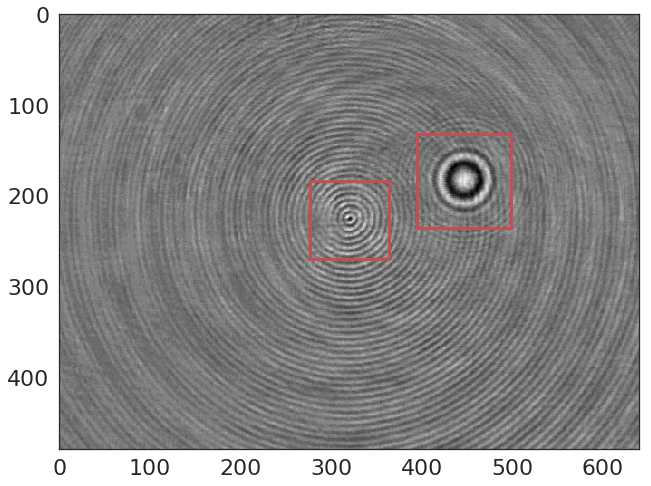

In [10]:
# Plot boxes onto circle transform
fig, ax = plt.subplots()
ax.imshow(frame, cmap='gray')
for feature in features:
    x, y, w, h = feature
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

## Fit the frame.
1. Find the feature in the image.
2. Crop to the relevant region.
3. Use mie_fit to fit the image.

In [11]:
# Crop the frame to a reasonable size for fitting.
xc, yc, w, h = features[0]
xc, yc, w, h = int(xc), int(yc), int(w), int(h)
cropped_norm = frame[yc-h//2:yc+h//2, xc-w//2:xc+w//2]

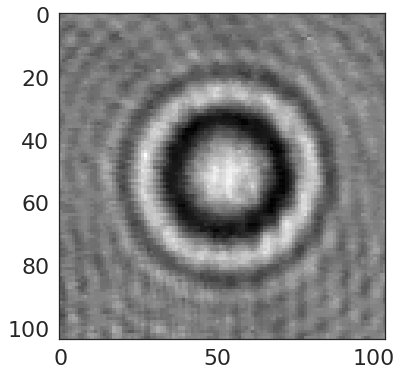

In [12]:
# Check the crop.
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cropped_norm, cmap='gray', interpolation=None)

In [19]:
# Guess where the particle is.
guesses = [0,     # x guess [pixel]
           0,     # y guess 
           160,   # z guess
           .83,   # a_p [um]
           1.41,   # n_p [1]
           1.340,                    # n_m
           0.048,                    # mpp
           0.447]                    # lamb 

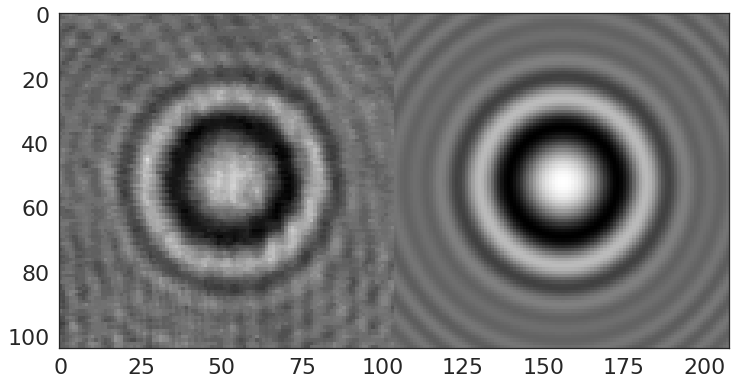

In [20]:
# Plot
shape = cropped_norm.shape
h = LMHologram.LMHologram(coordinates=Instrument.coordinates(shape))
h.particle.r_p = [shape[0] // 2, shape[1] // 2, guesses[2]]
h.particle.a_p = guesses[3]
h.particle.n_p = guesses[4]
h.instrument.n_m = guesses[5]
h.instrument.mpp = guesses[6]
h.instrument.wavelength = guesses[7]
hol = h.hologram().reshape(shape)
plt.imshow(np.hstack([cropped_norm, hol]), cmap='gray')

In [14]:
init_params = dict(zip(['x', 'y', 'z', 'a_p', 'n_p', 'n_m', 'mpp', 'lamb'], guesses))

In [15]:
mie_fit = Mie_Fitter(init_params)
mie_fit.mie_loss(mie_fit.p, cropped_norm, cropped_norm.shape)
result = mie_fit.fit(cropped_norm)

In [16]:
# Fit the frame to the Lorenz-Mie Theory.
result.params

Parameters([('x',
             <Parameter 'x', value=0.9368182839928433 +/- 0.0145, bounds=[-inf:inf]>),
            ('y',
             <Parameter 'y', value=-0.5317402310752872 +/- 0.0144, bounds=[-inf:inf]>),
            ('z',
             <Parameter 'z', value=160.08453864708295 +/- 0.119, bounds=[-inf:inf]>),
            ('a_p',
             <Parameter 'a_p', value=0.7845333374690776 +/- 0.00195, bounds=[-inf:inf]>),
            ('n_p',
             <Parameter 'n_p', value=1.3997255654152267 +/- 0.000342, bounds=[-inf:inf]>),
            ('n_m', <Parameter 'n_m', value=1.34 (fixed), bounds=[-inf:inf]>),
            ('mpp', <Parameter 'mpp', value=0.048 (fixed), bounds=[-inf:inf]>),
            ('lamb',
             <Parameter 'lamb', value=0.447 (fixed), bounds=[-inf:inf]>)])

In [17]:
result.redchi

0.7818431564949856

## Show the result side-by-side.

In [18]:
x, y, z, a_p, n_p, n_m, mpp, lamb = result.params.valuesdict().values()

In [19]:
h = LMHologram.LMHologram(coordinates=Instrument.coordinates(shape))
h.particle.r_p = [shape[0] // 2, shape[1] // 2, guesses[2]]
h.particle.a_p = a_p
h.particle.n_p = n_p
h.instrument.n_m = n_m
h.instrument.mpp = mpp
h.instrument.wavelength = lamb
hol = h.hologram().reshape(shape)

In [20]:
residual = result.residual.reshape(*cropped_norm.shape)

Redchi: 0.7818431564949856


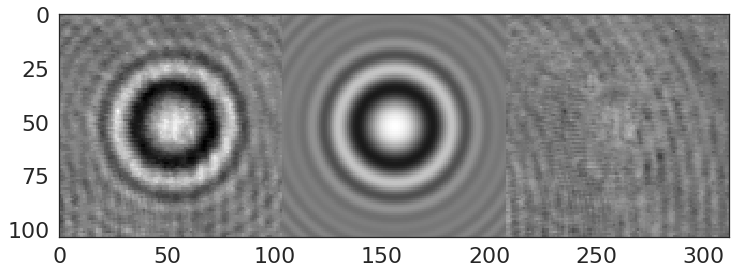

In [22]:
noise = .05
mega_image = np.hstack([cropped_norm, hol, residual*noise+1.0])
fig, ax = plt.subplots(figsize=(12, 36))
ax.imshow(mega_image, cmap='gray', interpolation=None)
print("Redchi: " + str(result.redchi))